In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def draw(xs, ms, zlist, Rs):  ###graphslam3draw
    ##世界の描画##
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111) 
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    
    ##軌跡の描画##
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")

    ##センサ値の描画##
    for t in range(len(xs)):
        if t not in zlist: continue
            
        for obs in zlist[t]:
            x, y, theta = xs[t]
            ell, phi = obs[1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
        
    ##ランドマークの推定位置の描画## 
    ax.scatter([e[0] for e in ms], [e[1] for e in ms], s=10, marker="*", color="blue")
    print(ms)
    
    ##R_tの描画##  #追加
    for t in range(1,t_end+1):
        ax.add_patch( sigma_ellipse(xs[t], Rs[t], 3) )
    
    ##描画実行##
    plt.show()

In [3]:
###データの読み込み###
delta = 0.0
xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
zlist = {} #センサ値のデータ（ステップ数をキーにして、さらにその中にランドマークのIDとセンサ値をタプルで保存）
us = {}    #制御入力のデータ（ステップ数をキーにして保存）

with open("log.txt") as f:
    for line in f.readlines():
        tmp = line.rstrip().split()
        
        step = int(tmp[1])
        if tmp[0] == "delta":
            delta = float(tmp[1])
        elif tmp[0] == "x": #姿勢のレコードの場合
            xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
        elif tmp[0] == "z": #センサ値のレコードの場合
            if step not in zlist:  #まだ辞書が空の時は空の辞書を作る
                zlist[step] = []
            zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4])]).T))
        elif tmp[0] == "u": #制御入力の場合
            us[step] = np.array([float(tmp[2]), float(tmp[3])]).T

In [4]:
##空の精度行列と一次の項のベクトルの準備## 
t_end = len(xs) - 1 #step数（数式中のT）

##観測されたランドマークのリスト（精度行列に設けるもの）のセット##
observed_landmarks = set()
for t in range(len(xs)):
    if t not in zlist: continue

    for obs in zlist[t]:
        observed_landmarks.add(obs[0])

##精度行列の次元を求めて精度行列と一次の項のベクトルの初期化##
dim = (t_end + 1)*3 + len(observed_landmarks)*2
Omega = np.zeros((dim, dim))
xi = np.zeros((dim, 1))

##確認##
print(t_end)                           #終了時刻
print(observed_landmarks) #観測されたランドマークのID
print(Omega)                        #精度行列
print(xi)                                  #一次の項のベクトル

46
{0, 1, 2, 3, 4, 5}
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]


In [5]:
mxs, mys = {}, {} #ランドマークごとにx座標を貯める辞書
for j in observed_landmarks: mxs[j], mys[j] = [], [] #ランドマークごとに座標のリストを初期化

for t in range(len(xs)):
    if t not in zlist: continue  #センサ値のないステップは飛ばす
            
    for obs in zlist[t]:             #センサ値ごとに地図上の位置を計算
        x, y, theta = xs[t]         #デッドレコニング上の座標
        ell, phi = obs[1]            #センサ値
        j = obs[0]                      #ランドマークのID
        mx = x + ell*math.cos(theta + phi)    #ランドマークの座標
        my = y + ell*math.sin(theta + phi)    #ランドマークの座標
        
        mxs[j].append(mx)     #計算した座標をリストに加える
        mys[j].append(my)
        
mx_avg, my_avg = {}, {}
hat_ms = []
for j in observed_landmarks:  #ランドマークごとに平均値を出す
    mx_avg[j] = sum(mxs[j])/len(mxs[j])
    my_avg[j] = sum(mys[j])/len(mys[j])
    hat_ms.append(np.array([mx_avg[j], my_avg[j]]).T)
    
hat_xs = xs  #姿勢の初期値はxsをそのまま使う
hat_ms = hat_ms

print(hat_ms)

[array([-3.10663391,  2.83389521]), array([ 0.12290473, -4.63274186]), array([3.83304856, 0.19382236]), array([1.85539418, 2.74410307]), array([ 1.30391713, -0.32147491]), array([-3.62025933, -0.28554645])]


In [6]:
##Ω_0を作る## ###graphslam3omegazero
alpha = 0.001
Sigma_0 = np.diag([0.001**2, 0.001**2, 0.001**2])

Om_0 = np.linalg.inv(Sigma_0) #3x3の精度行列としてΩ0を作る
xi_0 = Om_0.dot(hat_xs[0])

print("Ω0 = ", Om_0)
print("ξ0 =", xi_0)

Ω0 =  [[1000000.       0.       0.]
 [      0. 1000000.       0.]
 [      0.       0. 1000000.]]
ξ0 = [-2000000. -2000000.        0.]


In [7]:
##Ωxx,ξxxを作る##   ###graphslam3motioninfo
motion_noise_stds = {"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}

def R(t): #R_tを返す
    theta = hat_xs[t-1][2]
    nu, omega = us[t]
    if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける
    if abs(nu) < 1e-5:         nu = 1e-5
        
    st, ct = math.sin(theta), math.cos(theta)
    stw, ctw = math.sin(theta + omega*delta), math.cos(theta + omega*delta)
    A = np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*delta*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*delta*stw],
                                 [0,                                delta]] )
    M = np.diag(
        [motion_noise_stds["nn"]**2*abs(nu)/delta +motion_noise_stds["no"]**2*abs(omega)/delta,
             motion_noise_stds["on"]**2*abs(nu)/delta + motion_noise_stds["oo"]**2*abs(omega)/delta]
    )
#    return A.dot(M).dot(A.T) + np.diag([0.01**2, 0.01**2, 0.01**2]) #xyθ方向に誤差を混ぜておく
    return np.diag([0.01**2, 0.01**2, 0.01**2]) 

def F(t): #F_x_{t-1}を返す（添字注意）
    F = np.array(np.eye(3))
    theta = hat_xs[t-1][2]
    nu, omega = us[t]
    if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける
    if abs(nu) < 1e-5:         nu = 1e-5
    
    F[0, 2] = nu / omega * (math.cos(theta + omega * delta) - math.cos(theta))
    F[1, 2] = nu / omega * (math.sin(theta + omega * delta) - math.sin(theta))
        
    return F

##必要な行列を先に計算##
Rs, Fs, Rinvs = {}, {}, {}
for t in range(1, t_end+1):
    Rs[t] = R(t)
    Rinvs[t] = np.linalg.inv(Rs[t])
    Fs[t-1] = F(t)
    
##各x_{t-1}, x_tペアの精度行列と一次の項のベクトルを作る##
Omxx_ul, Omxx_ur, Omxx_bl, Omxx_br = {}, {}, {}, {} #x_{t-1}とx_tに対する精度行列を保管する辞書
xixx_u, xixx_b = {}, {}

for t in range(1, t_end+1):
    Omxx_ul[(t-1, t)] = Fs[t-1].T.dot(Rinvs[t]).dot(Fs[t-1])
    Omxx_ur[(t-1, t)] = -Fs[t-1].T.dot(Rinvs[t])
    Omxx_bl[(t-1, t)] = -Rinvs[t].dot(Fs[t-1].T)
    Omxx_br[(t-1, t)] = Rinvs[t]
    
    nu, omega = us[t]
    xixx_b[(t-1, t)] = Rinvs[t].dot(IdealRobot.state_transition(nu, omega, delta, xs[t-1]) - Fs[t-1].dot(xs[t-1])) #下の3行から計算
    xixx_u[(t-1, t)] = - Fs[t-1].T.dot(xixx_b[(t-1, t)])

In [8]:
distance_dev_rate=0.14  ###graphslam3obs###
direction_dev=0.05

def HxHmQ(t, j):
    x, y, _ = hat_xs[t]
    mx, my = hat_ms[j]
    lxm = math.sqrt((x-mx)**2 + (y-my)**2)
    
    ##Qの計算##
    Q = np.diag(np.array([(distance_dev_rate*lxm)**2, direction_dev**2]))
    Qinv = np.linalg.inv(Q)
            
    ##Hの計算##
    Hx = np.array([[(x - mx)/lxm, (y - my)/lxm, 0.0],
                              [(my - y)/(lxm**2), (x - mx)/(lxm**2), -1.0]])
    Hm = - Hx[0:2, 0:2]
    return Hx, Hm, Q, Qinv

Omxm_ul, Omxm_ur, Omxm_bl, Omxm_br = {}, {}, {}, {}
xixm_u, xixm_b = {}, {}
    
for t in range(1, t_end+1):
    if t not in zlist:          continue
    
    for obs in zlist[t]:
        j, z = obs
        Hx, Hm, Q, Qinv = HxHmQ(t, j)
        
        Omxm_ul[(t, j)] = Hx.T.dot(Qinv).dot(Hx)
        Omxm_ur[(t, j)] = Hx.T.dot(Qinv).dot(Hm)
        Omxm_bl[(t, j)] = Hm.T.dot(Qinv).dot(Hx)
        Omxm_br[(t, j)] = Hm.T.dot(Qinv).dot(Hm)
        
        tmp = Qinv.dot(Hx.dot(hat_xs[t]) + Hm.dot(hat_ms[j]) + np.array(z) - IdealCamera.relative_polar_pos(hat_xs[t], hat_ms[j]))
        xixm_u[(t, j)] = Hx.T.dot(tmp)
        xixm_b[(t, j)] = Hm.dot(tmp)

In [9]:
Omega = np.zeros((dim, dim))
xi = np.zeros((dim, 1))

Omega[0:3, 0:3] += Om_0
xi[0:3, 0] += xi_0

for t in range(1, t_end+1):
    Omega[(t-1)*3:t*3, (t-1)*3:t*3] +=  Omxx_ul[(t-1, t)]
    Omega[(t-1)*3:t*3, t*3:(t+1)*3] +=  Omxx_ur[(t-1, t)]
    Omega[t*3:(t+1)*3, (t-1)*3:t*3] +=  Omxx_bl[(t-1, t)]
    Omega[t*3:(t+1)*3, t*3:(t+1)*3] +=  Omxx_br[(t-1, t)]
    
    xi[(t-1)*3:t*3, 0] += xixx_u[(t-1, t)]
    xi[t*3:(t+1)*3, 0] += xixx_b[(t-1, t)]

[array([-3.10663391,  2.83389521]), array([ 0.12290473, -4.63274186]), array([3.83304856, 0.19382236]), array([1.85539418, 2.74410307]), array([ 1.30391713, -0.32147491]), array([-3.62025933, -0.28554645])]


<IPython.core.display.Javascript object>


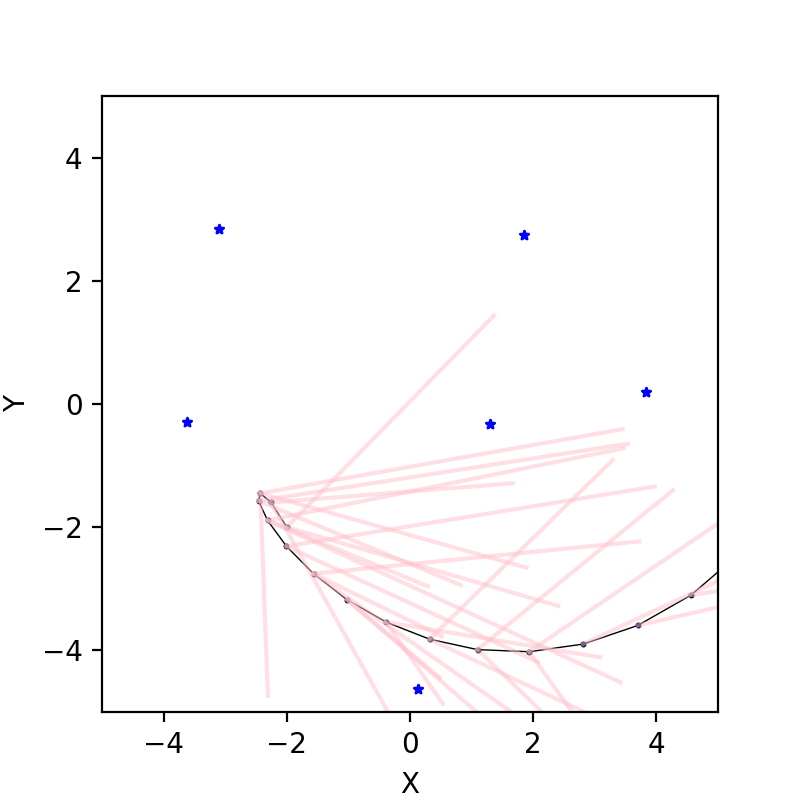

In [15]:
A = Omega[0:(t_end+1)*3 , 0:(t_end+1)*3 ]
b = xi[0:(t_end+1)*3, 0]

#A = Omega[0:6 , 0:6 ]
#b = xi[0:6, 0]

c = np.linalg.inv(A).dot(b)
for t in range(1,t_end+1):
    hat_xs[t] = c[t*3:t*3+3]
    
draw(hat_xs, hat_ms, zlist, Rs) 

In [11]:
IdealRobot.state_transition(nu, omega, delta, xs[0])

array([-1.60202769, -1.96518193,  0.17453293])

In [12]:
np.linalg.inv(A)

array([[ 9.98367210e-07,  1.34533987e-09,  9.65425534e-10, ...,
        -4.93941858e-11,  2.15075699e-09,  2.89758497e-10],
       [ 7.22156675e-10,  9.96274705e-07, -6.57915182e-09, ...,
        -1.97662723e-11,  8.60790879e-10,  1.15966251e-10],
       [ 1.69178635e-10,  1.26552059e-09,  9.93035673e-07, ...,
        -2.38048805e-11,  1.03643314e-09,  1.39629789e-10],
       ...,
       [ 1.42810949e-11,  6.96787147e-12, -6.94131264e-12, ...,
         1.50818901e-04,  6.13055812e-05,  8.14168775e-05],
       [ 1.49887720e-10,  7.30757944e-11, -7.29494303e-11, ...,
         1.79909221e-05,  7.32916429e-04,  4.25896554e-05],
       [-5.11436442e-11, -2.49226949e-11,  2.48760675e-11, ...,
        -1.42831582e-04, -1.30005214e-04,  1.02890917e-04]])

In [13]:
b

array([-2.00397972e+06, -2.00034818e+06, -1.74532925e+03, -5.95386570e+01,
       -1.22941514e+01,  2.78544523e+02, -1.70707613e+02, -6.40145908e+01,
        5.57089046e+02, -2.62253138e+02, -1.53454119e+02,  8.35633568e+02,
       -3.24725387e+02, -2.74785691e+02,  1.11417809e+03, -3.50199149e+02,
       -4.20102542e+02,  1.39272261e+03, -3.32697784e+02, -5.79786659e+02,
        1.67126714e+03, -2.68532897e+02, -7.42959100e+02,  1.94981166e+03,
       -1.56544633e+02, -8.97993671e+02,  2.22835618e+03,  1.76859631e+00,
       -1.03307280e+03,  2.50690071e+03,  2.02237784e+02, -1.13676253e+03,
        2.78544523e+03,  4.38130514e+02, -1.19858266e+03,  3.06398975e+03,
        7.00375011e+02, -1.20954791e+03,  3.34253427e+03,  9.77893636e+02,
       -1.16265681e+03,  3.62107880e+03,  1.25803396e+03, -1.05330709e+03,
        3.89962332e+03,  1.52708143e+03, -8.79618676e+02,  4.17816784e+03,
        1.77083415e+03, -6.42648820e+02,  4.45671236e+03,  1.97521754e+03,
       -3.46488265e+02,  

In [14]:
np.linalg.inv(A).dot(np.array([-2.00005652e+06, -1.99967079e+06,  5.42043462e+01,  5.65191682e+01,
       -3.29213471e+02,  7.87813868e+01]).T)

ValueError: shapes (141,141) and (6,) not aligned: 141 (dim 1) != 6 (dim 0)

In [ ]:
pos = (t_end+1)*3 
for j in observed_landmarks:
    for t in range(1, t_end+1):
        if not (t, j) in Omxm_ul: continue
            
        Omega[t*3:(t+1)*3, t*3:(t+1)*3] +=  Omxm_ul[(t, j)]
        Omega[t*3:(t+1)*3, pos:pos+2] +=  Omxm_ur[(t, j)]
        Omega[pos:pos+2, t*3:(t+1)*3] +=  Omxm_bl[(t, j)]
        Omega[pos:pos+2, pos:pos+2] +=  Omxm_br[(t, j)]
        
        xi[t*3:(t+1)*3, 0] += xixm_u[(t, j)]
        xi[pos:pos+2, 0] += xixm_b[(t, j)]
        
    pos += 2
    
np.linalg.inv(Omega).dot(xi)

In [ ]:
Omega

In [ ]:
(-7.65881707e-01)/np.pi*180

In [ ]:
5.0/180*math.pi*180/np.pi*3